<a href="https://colab.research.google.com/github/shadinn/Torche-Analysis/blob/main/Torche_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing standard libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import os

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

## Reading data and preprocessing

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/belajar/RFM/customers.xlsx')
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date_Invoice  2288 non-null   datetime64[ns]
 1   Invoice       2244 non-null   object        
 2   Email         2160 non-null   object        
 3   Name          2278 non-null   object        
 4   User_ID       2288 non-null   object        
 5   Courses_ID    2288 non-null   object        
 6   Tutor_ID      2288 non-null   object        
 7   Harga         2287 non-null   float64       
 8   universitas   2288 non-null   object        
 9   tutor         2288 non-null   object        
 10  course        2288 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 196.8+ KB


In [ ]:
missing_values = df.isnull().sum()

print(missing_values)

Date_Invoice      0
Invoice          44
Email           128
Name             10
User_ID           0
Courses_ID        0
Tutor_ID          0
Harga             1
universitas       0
tutor             0
course            0
dtype: int64


membuat kolom baru Transaction_ID

In [ ]:
df['Transaction_ID'] = df.index + 1
df['Transaction_ID'] = 'Inv_' + df['Transaction_ID'].astype(str)
df.head()

Checking the total number of products, transactions and customers.

In [ ]:
pd.DataFrame([{'products': len(df['Courses_ID'].value_counts()),
               'Invoice': len(df['Invoice'].value_counts()),
               'Transactions' : len(df['Transaction_ID'].value_counts()),
               'customers': len(df['User_ID'].value_counts()),
               'universitas': len(df['universitas'].value_counts())
              }], columns = ['products', 'Invoice','Transactions', 'customers','universitas'], index = ['quantity'])

,products,Invoice,Transactions,customers,universitas
quantity,28,450,2288,574,29


In [ ]:
from google.colab import files
df.to_excel('dataset_torce.xlsx')
files.download('dataset_torce.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cohort Analysis

What is Cohort Analysis?

A cohort is a set of users who share similar characteristics over time. Cohort analysis groups the users into mutually exclusive groups and their behaviour is measured over time.

It can provide information about product and customer lifecycle.

There are three types of cohort analysis:
1. Time cohorts: It groups customers by their purchase behaviour over time.
2. Behaviour cohorts: It groups customers by the product or service they signed up for.
3. Size cohorts: Refers to various sizes of customers who purchase company's products or services. This categorization can be based on the amount of spending in some period of time.

Understanding the needs of various cohorts can help a company design custom-made services or products for particular segments.

In the following analysis, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [ ]:
cohort_data = df.loc[:,('Transaction_ID','Date_Invoice', 'Invoice', 'Email', 'Name', 'User_ID', 'Courses_ID',
       'Tutor_ID', 'Harga', 'universitas', 'tutor', 'course')]
cohort_data = cohort_data.rename(columns={'User_ID' : 'user_id',
                                          'Date_Invoice' : 'date_invoice',
                                          'universitas' : 'university'})
cohort_data['date_invoice'] = pd.to_datetime(cohort_data['date_invoice'], format='%d-%m-%Y')

## User

In [ ]:
class CohortAnalysis():
  def __init__(self, df, year, date_col, user_col):
    """
      df: pandas dataframe
      year (int): year you want to filter
      date_col (str): date column name in your df
      univ_name (str): univ you want to filter
      univ_col (str): univ column name
    """
    self.df = df
    self.year = year
    self.date_col = date_col
    self.univ_col = user_col

  def get_year_and_month(self):
    self.df['invoice_year'] = self.df[self.date_col].dt.year
    self.df['invoice_month'] = self.df[self.date_col].dt.month
    return self.df

  def filter_data(self):
    try:
      self.df = self.get_year_and_month()
      self.df = self.df[self.df['invoice_year'] == self.year]

      return self.df
    except KeyError:
        raise ValueError(f"kolom {self.univ_col} tidak ditemukan dalam dataframe")

  def get_first_invoice_month(self, grouper='user_id'):
    """
    grouper (str): column name to group the data
    """
    self.df = self.filter_data()
    cohort = self.df.groupby(grouper)['invoice_month'].min().reset_index()
    cohort.columns = ['user_id', 'first_invoice_month']
    self.df = self.df.merge(cohort, on=grouper, how='left')
    return self.df

  def get_month_diff(self):
    self.df['month_diff'] = self.df.apply(lambda row : row['invoice_month'] - row['first_invoice_month']
                                          if np.isfinite(row['invoice_month']) and np.isfinite(row['first_invoice_month'])
                                          else np.nan, axis=1)
    return self.df

  def check_and_pivot(self):
    df_new = self.get_month_diff()

    # month without any transaction
    exclude_first = [i for i in range(1, 13) if i not in df_new.first_invoice_month.unique()]
    exclude_diff = [i for i in range(0, 12) if i not in df_new.month_diff.unique()]

    # check if there is any month without transaction
    if len(exclude_first) > 0 or len(exclude_diff) > 0:
      new_df = df_new.copy()

      # make fake data
      new_rows =[]
      for i in exclude_first:
        x = {'date_invoice': f'2022-{i}-{i} 14:49:10',
             'user_id':'abc',
             'invoice_year': 2022,
             'invoice_month': i,
             'first_invoice_month':i,
             'month_diff': 0}
        new_rows.append(x)

      for i in exclude_diff:
        x = {'date_invoice': f'2022-{i}-{i} 14:49:10',
             'user_id':'abc',
             'invoice_year': 2022,
             'invoice_month': 12,
             'first_invoice_month':1,
             'month_diff': i}
        new_rows.append(x)

      # add fake data into new dataframe
      new_df = new_df.append(new_rows, ignore_index=True)

      pivot = pd.pivot_table(new_df,
                             index='first_invoice_month',
                             columns='month_diff',
                             values='user_id',
                             aggfunc=pd.Series.nunique)

      headers = [i for i in range(1, 13)]

      months = ['Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep',
                'Oct', 'Nov', 'Dec']

      months = {headers[i]: months[i] for i in range(len(headers))}

      # replace fake data with 0.0 in pivot table
      for i in exclude_first:
        pivot[0][i] = 0.0

      for i in exclude_diff:
        pivot[i][1] = 0.0

      pivot = pivot.rename(index=months)
      pivot.index.name = 'First Invoice Month'
      pivot.columns.name = 'Repeat Order After (month)'

      pivot = pivot.div(pivot[0], axis=0)
      pivot = pivot.fillna(0.0)

      return pivot

    else:
      pivot = pd.pivot_table(df_new,
                             index='first_invoice_month',
                             columns='month_diff',
                             values='user_id',
                             aggfunc=pd.Series.nunique)

      headers = [i for i in range(1, 13)]

      months = ['Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep',
                'Oct', 'Nov', 'Dec']

      months = {headers[i]: months[i] for i in range(len(headers))}

      pivot = pivot.rename(index=months)
      pivot.index.name = 'First Invoice Month'
      pivot.columns.name = 'Repeat Order After (month)'

      pivot = pivot.div(pivot[0], axis=0)
      pivot = pivot.fillna(0.0)
      return pivot

  def visualize(self, color, figsize=(12, 10)):
    pivot = self.check_and_pivot()
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    fig.set_dpi = 300
    sns.heatmap(pivot, cmap=color, annot=True,
                ax=axes, fmt='.0%')

    axes.set_xlabel("Repeat Order After (Month)", weight='bold')
    axes.set_ylabel("First Invoice Month", weight='bold')
    axes.set_title("Customer Cohort");
    axes.set_yticklabels(axes.get_yticklabels(), rotation=360)

    fig.savefig(os.path.join(os.getcwd(),
              "Customer Course Cohort.png"),
                bbox_inches='tight', dpi=fig.dpi)


<ipython-input-53-429b28b04cd9>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-53-429b28b04cd9>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


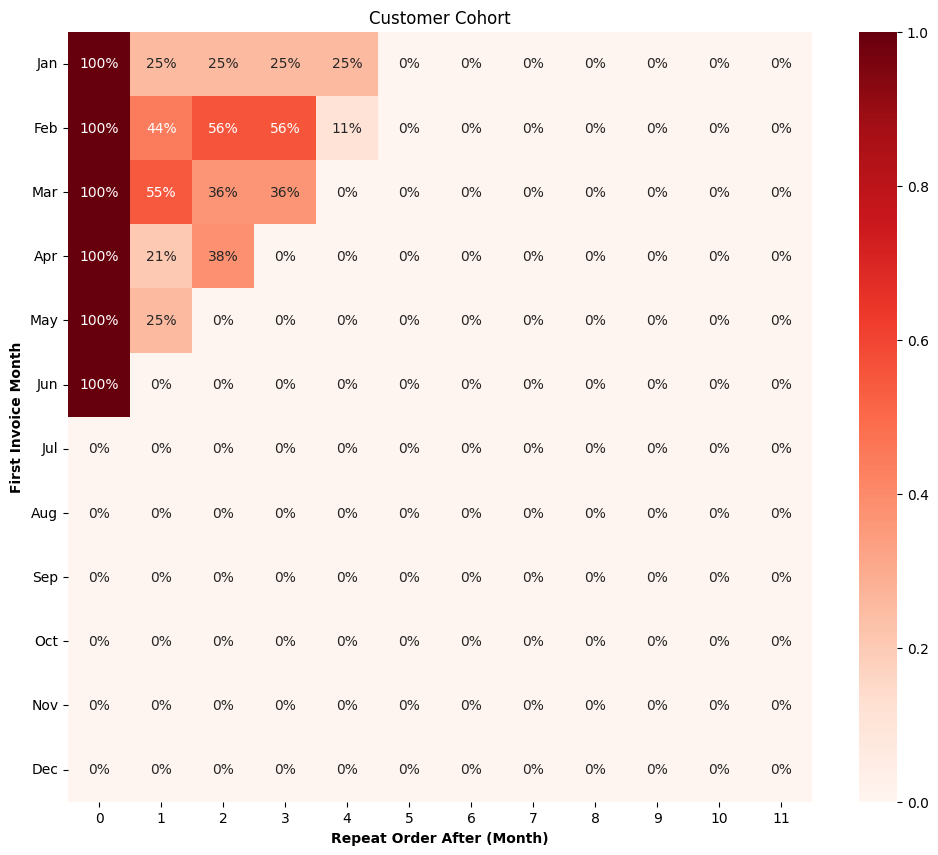

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2023,
                        date_col='date_invoice',
                        user_col='user_id')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

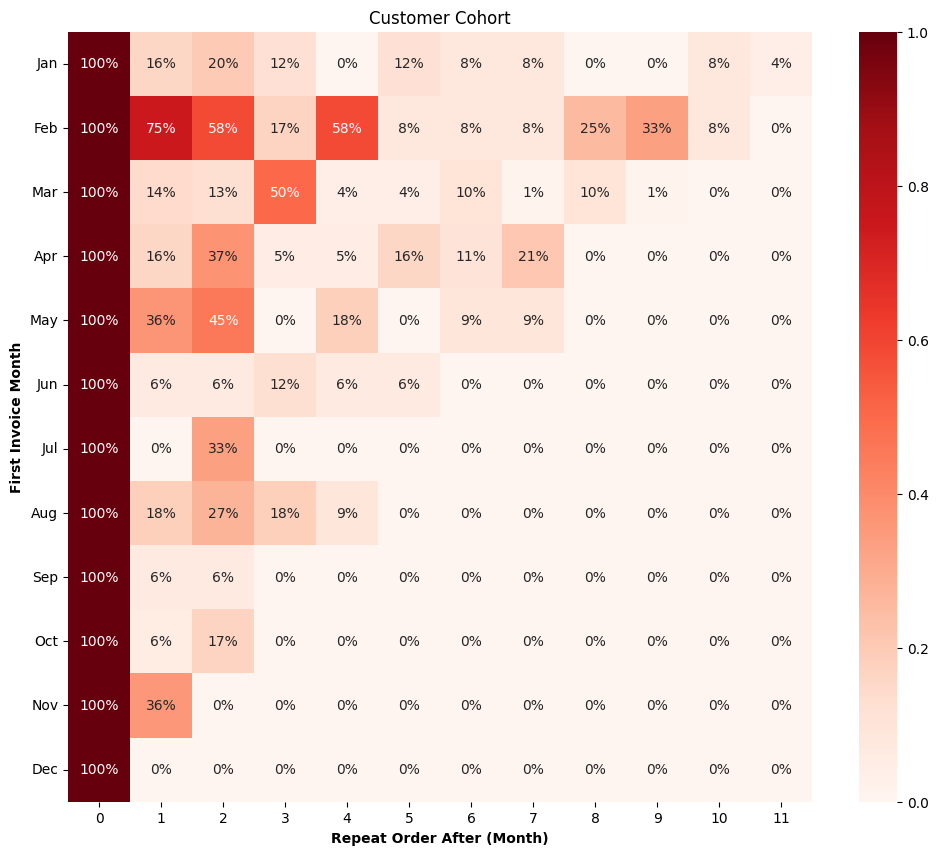

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2022,
                        date_col='date_invoice',
                        user_col='user_id')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

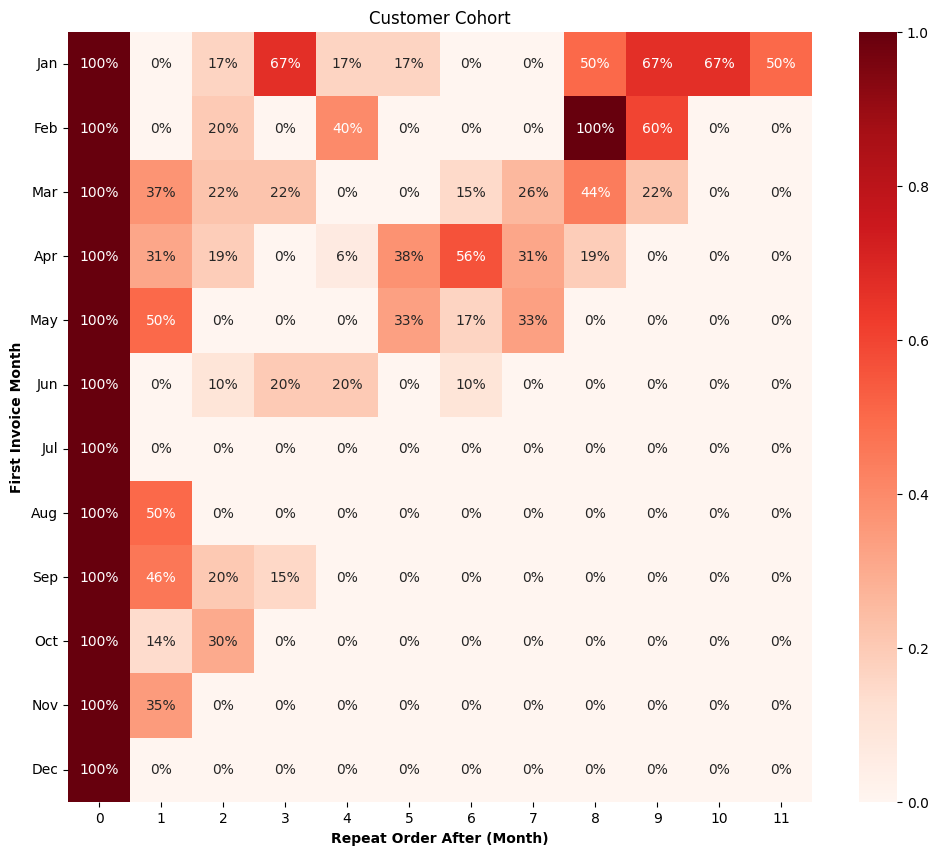

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2021,
                        date_col='date_invoice',
                        user_col='user_id')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

In [ ]:
cohort.get_first_invoice_month()

,date_invoice,user_id,university,order_month,cohort,invoice_year,invoice_month,first_invoice_month_x,month_diff,first_invoice_month_y
0,2021-01-04,U2020-0014,Universitas Indonesia,2021-01,2020-10,2021,1,1,0,1
1,2021-01-04,U2021-0031,Universitas Indonesia,2021-01,2021-01,2021,1,1,0,1
2,2021-01-04,U2021-0052,Universitas Indonesia,2021-01,2021-01,2021,1,1,0,1
3,2021-01-04,U2020-0014,Universitas Indonesia,2021-01,2020-10,2021,1,1,0,1
4,2021-01-04,U2021-0031,Universitas Indonesia,2021-01,2021-01,2021,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
899,2021-12-21,U2021-0089,Universitas Indonesia,2021-12,2021-11,2021,12,11,1,11
900,2021-12-21,U2020-0047,Universitas Indonesia,2021-12,2020-10,2021,12,11,1,11
901,2021-12-21,U2021-0167,Universitas Indonesia,2021-12,2021-12,2021,12,12,0,12
902,2021-12-21,U2020-0091,Universitas Indonesia,2021-12,2020-09,2021,12,12,0,12


<ipython-input-33-f9f5c118153d>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-33-f9f5c118153d>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


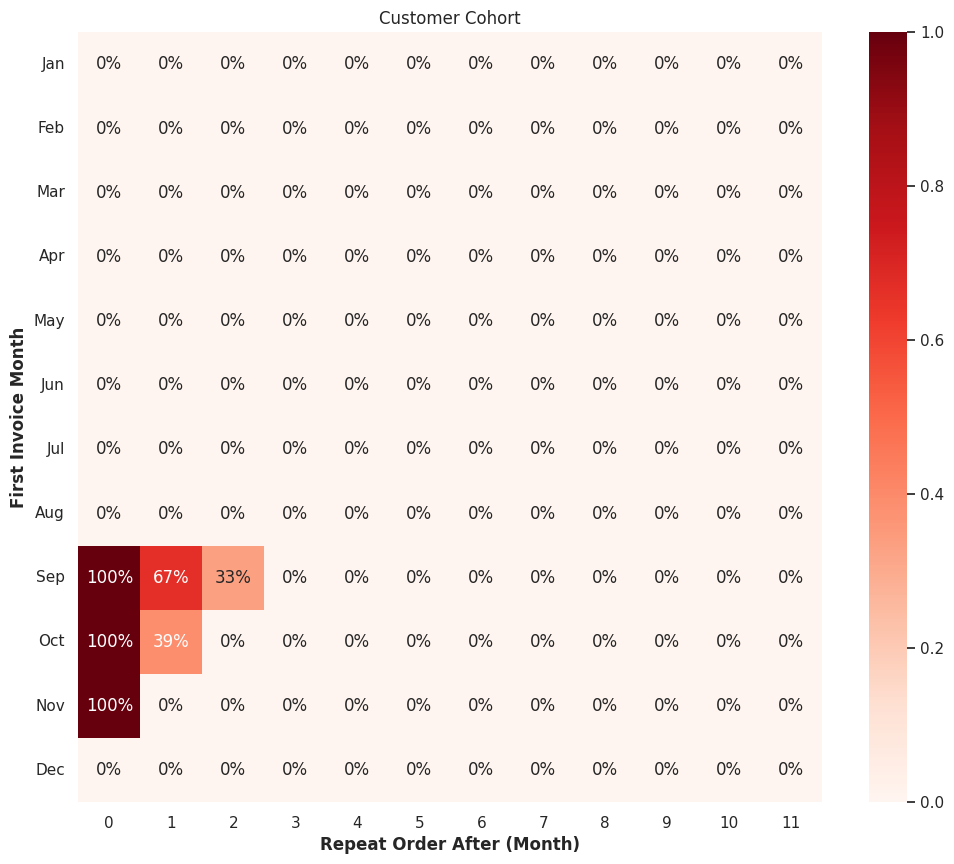

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2020,
                        date_col='date_invoice',
                        user_col='user_id')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

## Universitas

In [ ]:
class CohortAnalysis():
  def __init__(self, df, year, date_col, univ_col, univ_name):
    """
      df: pandas dataframe
      year (int): year you want to filter
      date_col (str): date column name in your df
      univ_name (str): univ you want to filter
      univ_col (str): univ column name
    """
    self.df = df
    self.year = year
    self.date_col = date_col
    self.univ_col = univ_col
    self.univ_name = univ_name

  def get_year_and_month(self):
    self.df['invoice_year'] = self.df[self.date_col].dt.year
    self.df['invoice_month'] = self.df[self.date_col].dt.month
    return self.df

  def filter_data(self):
    try:
      self.df = self.get_year_and_month()
      self.df = self.df[(self.df['invoice_year'] == self.year) &
                        (self.df[self.univ_col] == self.univ_name)]
      return self.df
    except KeyError:
        raise ValueError(f"kolom {self.univ_col} tidak ditemukan dalam dataframe")

  def get_first_invoice_month(self, grouper='user_id'):
    """
    grouper (str): column name to group the data
    """
    self.df = self.filter_data()
    cohort = self.df.groupby(grouper)['invoice_month'].min().reset_index()
    cohort.columns = ['user_id', 'first_invoice_month']
    self.df = self.df.merge(cohort, on=grouper, how='left')
    return self.df

  def get_month_diff(self):
    self.df['month_diff'] = self.df.apply(lambda row : row['invoice_month'] - row['first_invoice_month']
                                          if np.isfinite(row['invoice_month']) and np.isfinite(row['first_invoice_month'])
                                          else np.nan, axis=1)
    return self.df

  def check_and_pivot(self):
    df_new = self.get_month_diff()

    # month without any transaction
    exclude_first = [i for i in range(1, 13) if i not in df_new.first_invoice_month.unique()]
    exclude_diff = [i for i in range(0, 12) if i not in df_new.month_diff.unique()]

    # check if there is any month without transaction
    if len(exclude_first) > 0 or len(exclude_diff) > 0:
      new_df = df_new.copy()

      # make fake data
      new_rows =[]
      for i in exclude_first:
        x = {'date_invoice': f'2022-{i}-{i} 14:49:10',
             'user_id':'abc',
             'university': self.univ_name,
             'invoice_year': 2022,
             'invoice_month': i,
             'first_invoice_month':i,
             'month_diff': 0}
        new_rows.append(x)

      for i in exclude_diff:
        x = {'date_invoice': f'2022-{i}-{i} 14:49:10',
             'user_id':'abc',
             'university': self.univ_name,
             'invoice_year': 2022,
             'invoice_month': 12,
             'first_invoice_month':1,
             'month_diff': i}
        new_rows.append(x)

      # add fake data into new dataframe
      new_df = new_df.append(new_rows, ignore_index=True)

      pivot = pd.pivot_table(new_df,
                             index='first_invoice_month',
                             columns='month_diff',
                             values='user_id',
                             aggfunc=pd.Series.nunique)

      headers = [i for i in range(1, 13)]

      months = ['Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep',
                'Oct', 'Nov', 'Dec']

      months = {headers[i]: months[i] for i in range(len(headers))}

      # replace fake data with 0.0 in pivot table
      for i in exclude_first:
        pivot[0][i] = 0.0

      for i in exclude_diff:
        pivot[i][1] = 0.0

      pivot = pivot.rename(index=months)
      pivot.index.name = 'First Invoice Month'
      pivot.columns.name = 'Repeat Order After (month)'

      pivot = pivot.div(pivot[0], axis=0)
      pivot = pivot.fillna(0.0)

      return pivot

    else:
      pivot = pd.pivot_table(df_new,
                             index='first_invoice_month',
                             columns='month_diff',
                             values='user_id',
                             aggfunc=pd.Series.nunique)

      headers = [i for i in range(1, 13)]

      months = ['Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep',
                'Oct', 'Nov', 'Dec']

      months = {headers[i]: months[i] for i in range(len(headers))}

      pivot = pivot.rename(index=months)
      pivot.index.name = 'First Invoice Month'
      pivot.columns.name = 'Repeat Order After (month)'

      pivot = pivot.div(pivot[0], axis=0)
      pivot = pivot.fillna(0.0)
      return pivot

  def visualize(self, color, figsize=(12, 10)):
    pivot = self.check_and_pivot()
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    fig.set_dpi = 300
    sns.heatmap(pivot, cmap=color, annot=True,
                ax=axes, fmt='.0%')

    axes.set_xlabel("Repeat Order After (Month)", weight='bold')
    axes.set_ylabel("First Invoice Month", weight='bold')
    axes.set_title(f"{self.univ_name} Course Cohort");
    axes.set_yticklabels(axes.get_yticklabels(), rotation=360)

    fig.savefig(os.path.join(os.getcwd(),
              f"{self.univ_name} Course Cohort.png"),
                bbox_inches='tight', dpi=fig.dpi)


Universitas Indonesia

<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


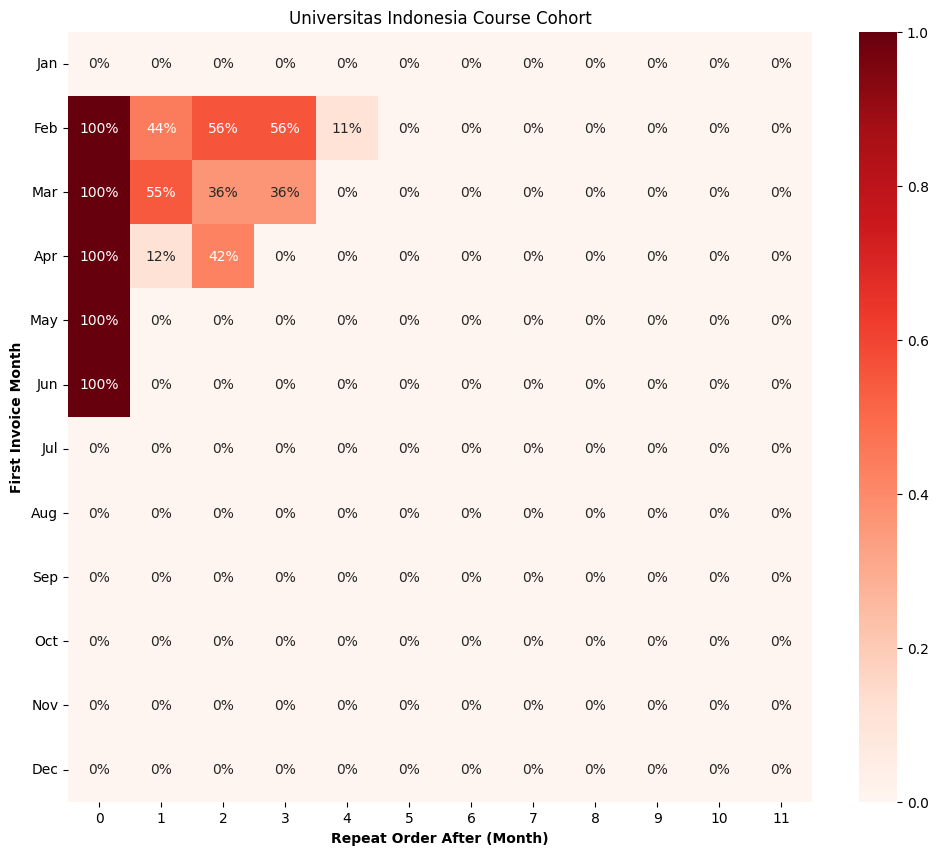

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2023,
                        date_col='date_invoice',
                        univ_col='university',
                        univ_name='Universitas Indonesia')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


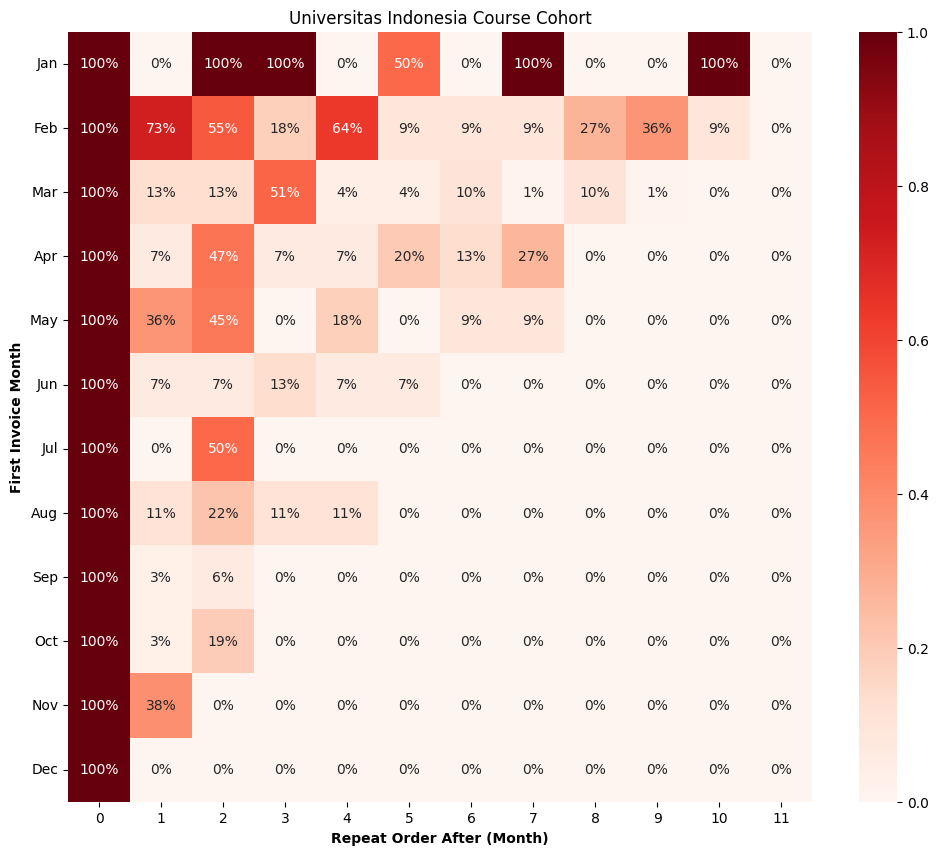

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2022,
                        date_col='date_invoice',
                        univ_col='university',
                        univ_name='Universitas Indonesia')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


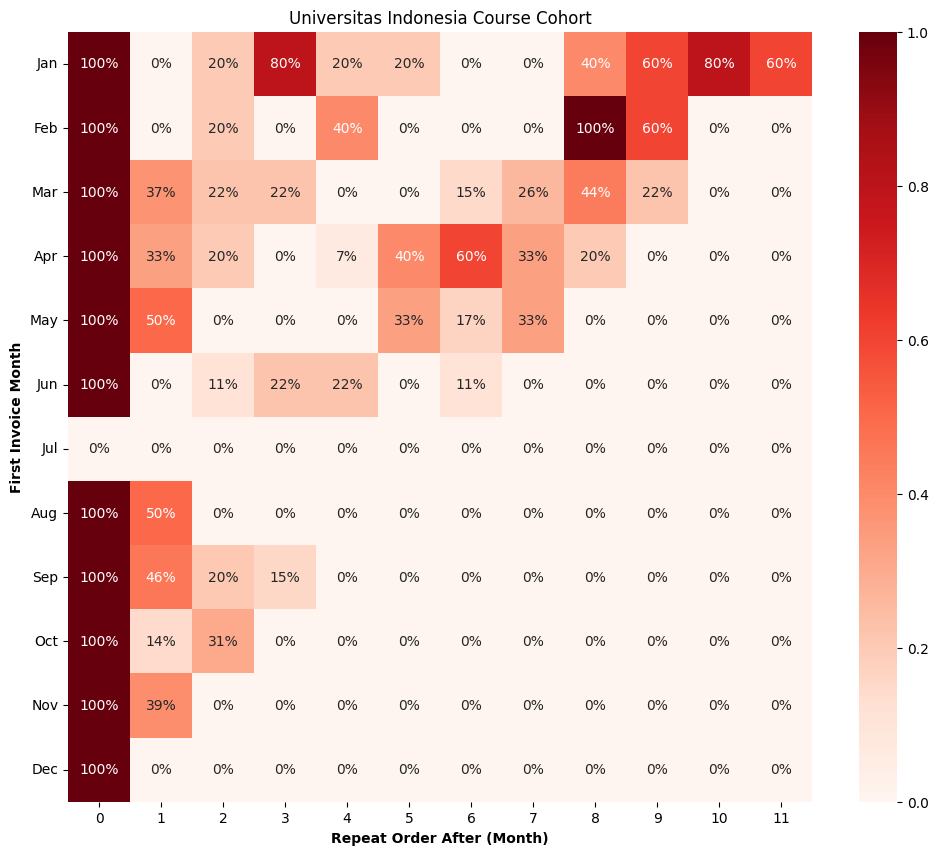

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2021,
                        date_col='date_invoice',
                        univ_col='university',
                        univ_name='Universitas Indonesia')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)
<ipython-input-11-bf5153a3fe45>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_rows, ignore_index=True)


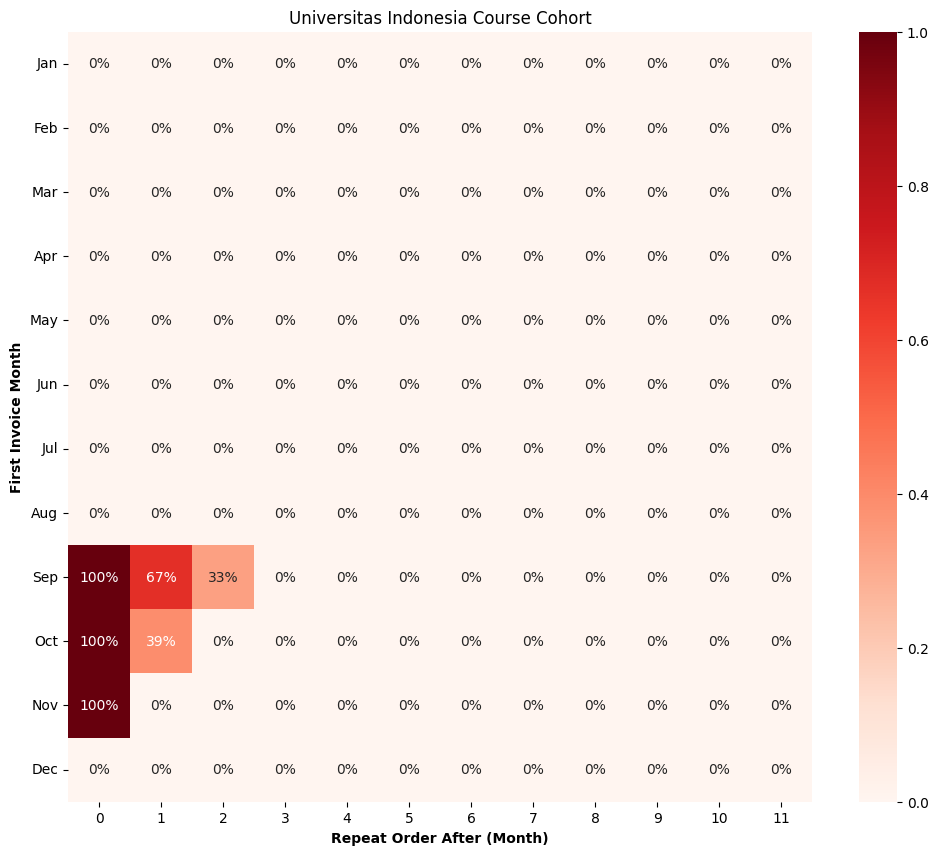

In [ ]:
cohort = CohortAnalysis(df=cohort_data,
                        year=2020,
                        date_col='date_invoice',
                        univ_col='university',
                        univ_name='Universitas Indonesia')
cohort.get_first_invoice_month()
cohort.get_month_diff()
cohort.check_and_pivot()
graph = cohort.visualize('Reds', (12, 10))
graph

# RFM Segmentation

In [ ]:
rfm_data = df[['Transaction_ID','Date_Invoice','User_ID','Harga']]

In [ ]:
# Start and end dates:
all_dates = (pd.to_datetime(rfm_data['Date_Invoice'])).apply(lambda x:x.date())
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2020-09-26
End date: 2023-06-10


In [ ]:
data_rfm = rfm_data[rfm_data['Date_Invoice'] >= pd.to_datetime(all_dates.min())]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,Transaction_ID,Date_Invoice,User_ID,Harga
0,Inv_1,2020-09-26,U2020-0020,58300.0
1,Inv_2,2020-09-26,U2020-0101,58300.0
2,Inv_3,2020-09-26,U2020-0001,58300.0
3,Inv_4,2020-09-29,U2020-0006,38809.0
4,Inv_5,2020-09-29,U2020-0027,38809.0


In [ ]:
snapshot_date = max(data_rfm.Date_Invoice) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2023-06-11


In [ ]:
# Aggregate data on a customer level
data = rfm_data.groupby(['User_ID'],as_index=False).agg({'Date_Invoice': lambda x: (snapshot_date - x.max()).days,
                                             'Transaction_ID': 'count',
                                             'Harga': 'sum'}).rename(columns = {'Date_Invoice': 'Recency',
                                                                                   'Transaction_ID': 'Frequency',
                                                                                   'Harga': 'MonetaryValue'})

# Check the first rows
data.head()

,User_ID,Recency,Frequency,MonetaryValue
0,U2020-0001,601,6,308300.0
1,U2020-0002,944,1,50000.0
2,U2020-0003,943,1,50000.0
3,U2020-0004,269,15,1157775.0
4,U2020-0005,941,3,154966.0


In [ ]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
data = data.assign(R = r_quartiles.values)

f_labels = range(1,4)
m_labels = range(1,5)
f_quartiles = pd.qcut(data['Frequency'], 4, labels = f_labels, duplicates='drop')
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels = m_labels, duplicates='drop')
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)
data.head()

,User_ID,Recency,Frequency,MonetaryValue,R,F,M
0,U2020-0001,601,6,308300.0,1,3,3
1,U2020-0002,944,1,50000.0,1,1,1
2,U2020-0003,943,1,50000.0,1,1,1
3,U2020-0004,269,15,1157775.0,3,3,4
4,U2020-0005,941,3,154966.0,1,2,3


In [ ]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data['RFM_Segment'] = data.apply(join_rfm, axis=1)
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data.head()

,User_ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,U2020-0001,601,6,308300.0,1,3,3,133,7
1,U2020-0002,944,1,50000.0,1,1,1,111,3
2,U2020-0003,943,1,50000.0,1,1,1,111,3
3,U2020-0004,269,15,1157775.0,3,3,4,334,10
4,U2020-0005,941,3,154966.0,1,2,3,123,6


Let us now analyse RFM Score distribution and their groups.

In [ ]:
data.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           765.5       1.0       48461.5    65
4           678.7       1.4       69212.1    57
5           531.1       1.7       91561.9    90
6           308.6       2.0      132981.9    66
7           298.4       2.3      189005.1    81
8           345.1       4.6      510782.0    64
9           262.2       5.6      649744.6    71
10          215.5      10.6      806560.1    52
11           89.4      15.1     2258030.4    28

In [ ]:
def create_segment(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'

data['General_Segment'] = data.apply(create_segment, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Low               725.0       1.2       58156.4   122
Middle            380.1       2.6      216002.7   301
Top               214.1       9.1     1001972.5   151

In [ ]:
data.head()

,User_ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,U2020-0001,601,6,308300.0,1,3,3,133,7,Middle
1,U2020-0002,944,1,50000.0,1,1,1,111,3,Low
2,U2020-0003,943,1,50000.0,1,1,1,111,3,Low
3,U2020-0004,269,15,1157775.0,3,3,4,334,10,Top
4,U2020-0005,941,3,154966.0,1,2,3,123,6,Middle


In [ ]:
from google.colab import files
data.to_excel('dataset_torce.xlsx')
files.download('dataset_torce.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Preprocessing data for Clustering

In [ ]:
pip install pywaffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 43.6 MB/s eta 0:00:00


In [ ]:
from matplotlib.patches import Rectangle
from pywaffle import Waffle
from math import isnan
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap
from sklearn.preprocessing import RobustScaler

In [ ]:
# Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import yellowbrick
import scipy.cluster.hierarchy as shc
import matplotlib.patches as patches



warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 600
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})
class clr:
    start = '\033[93m'+'\033[1m'
    color = '\033[93m'
    end = '\033[0m'

In the next section, we are going to prepare the data for Kmeans clustering on RFM Score data. To do this, we need to preprocess the data so that it can meet the key assumptions of Kmeans algorithm, which are:

1. The varaiables should be distributed symmetrically
2. Variables should have similar average values
3. Variables should have similar standard deviation values

<Axes: xlabel='MonetaryValue', ylabel='Density'>

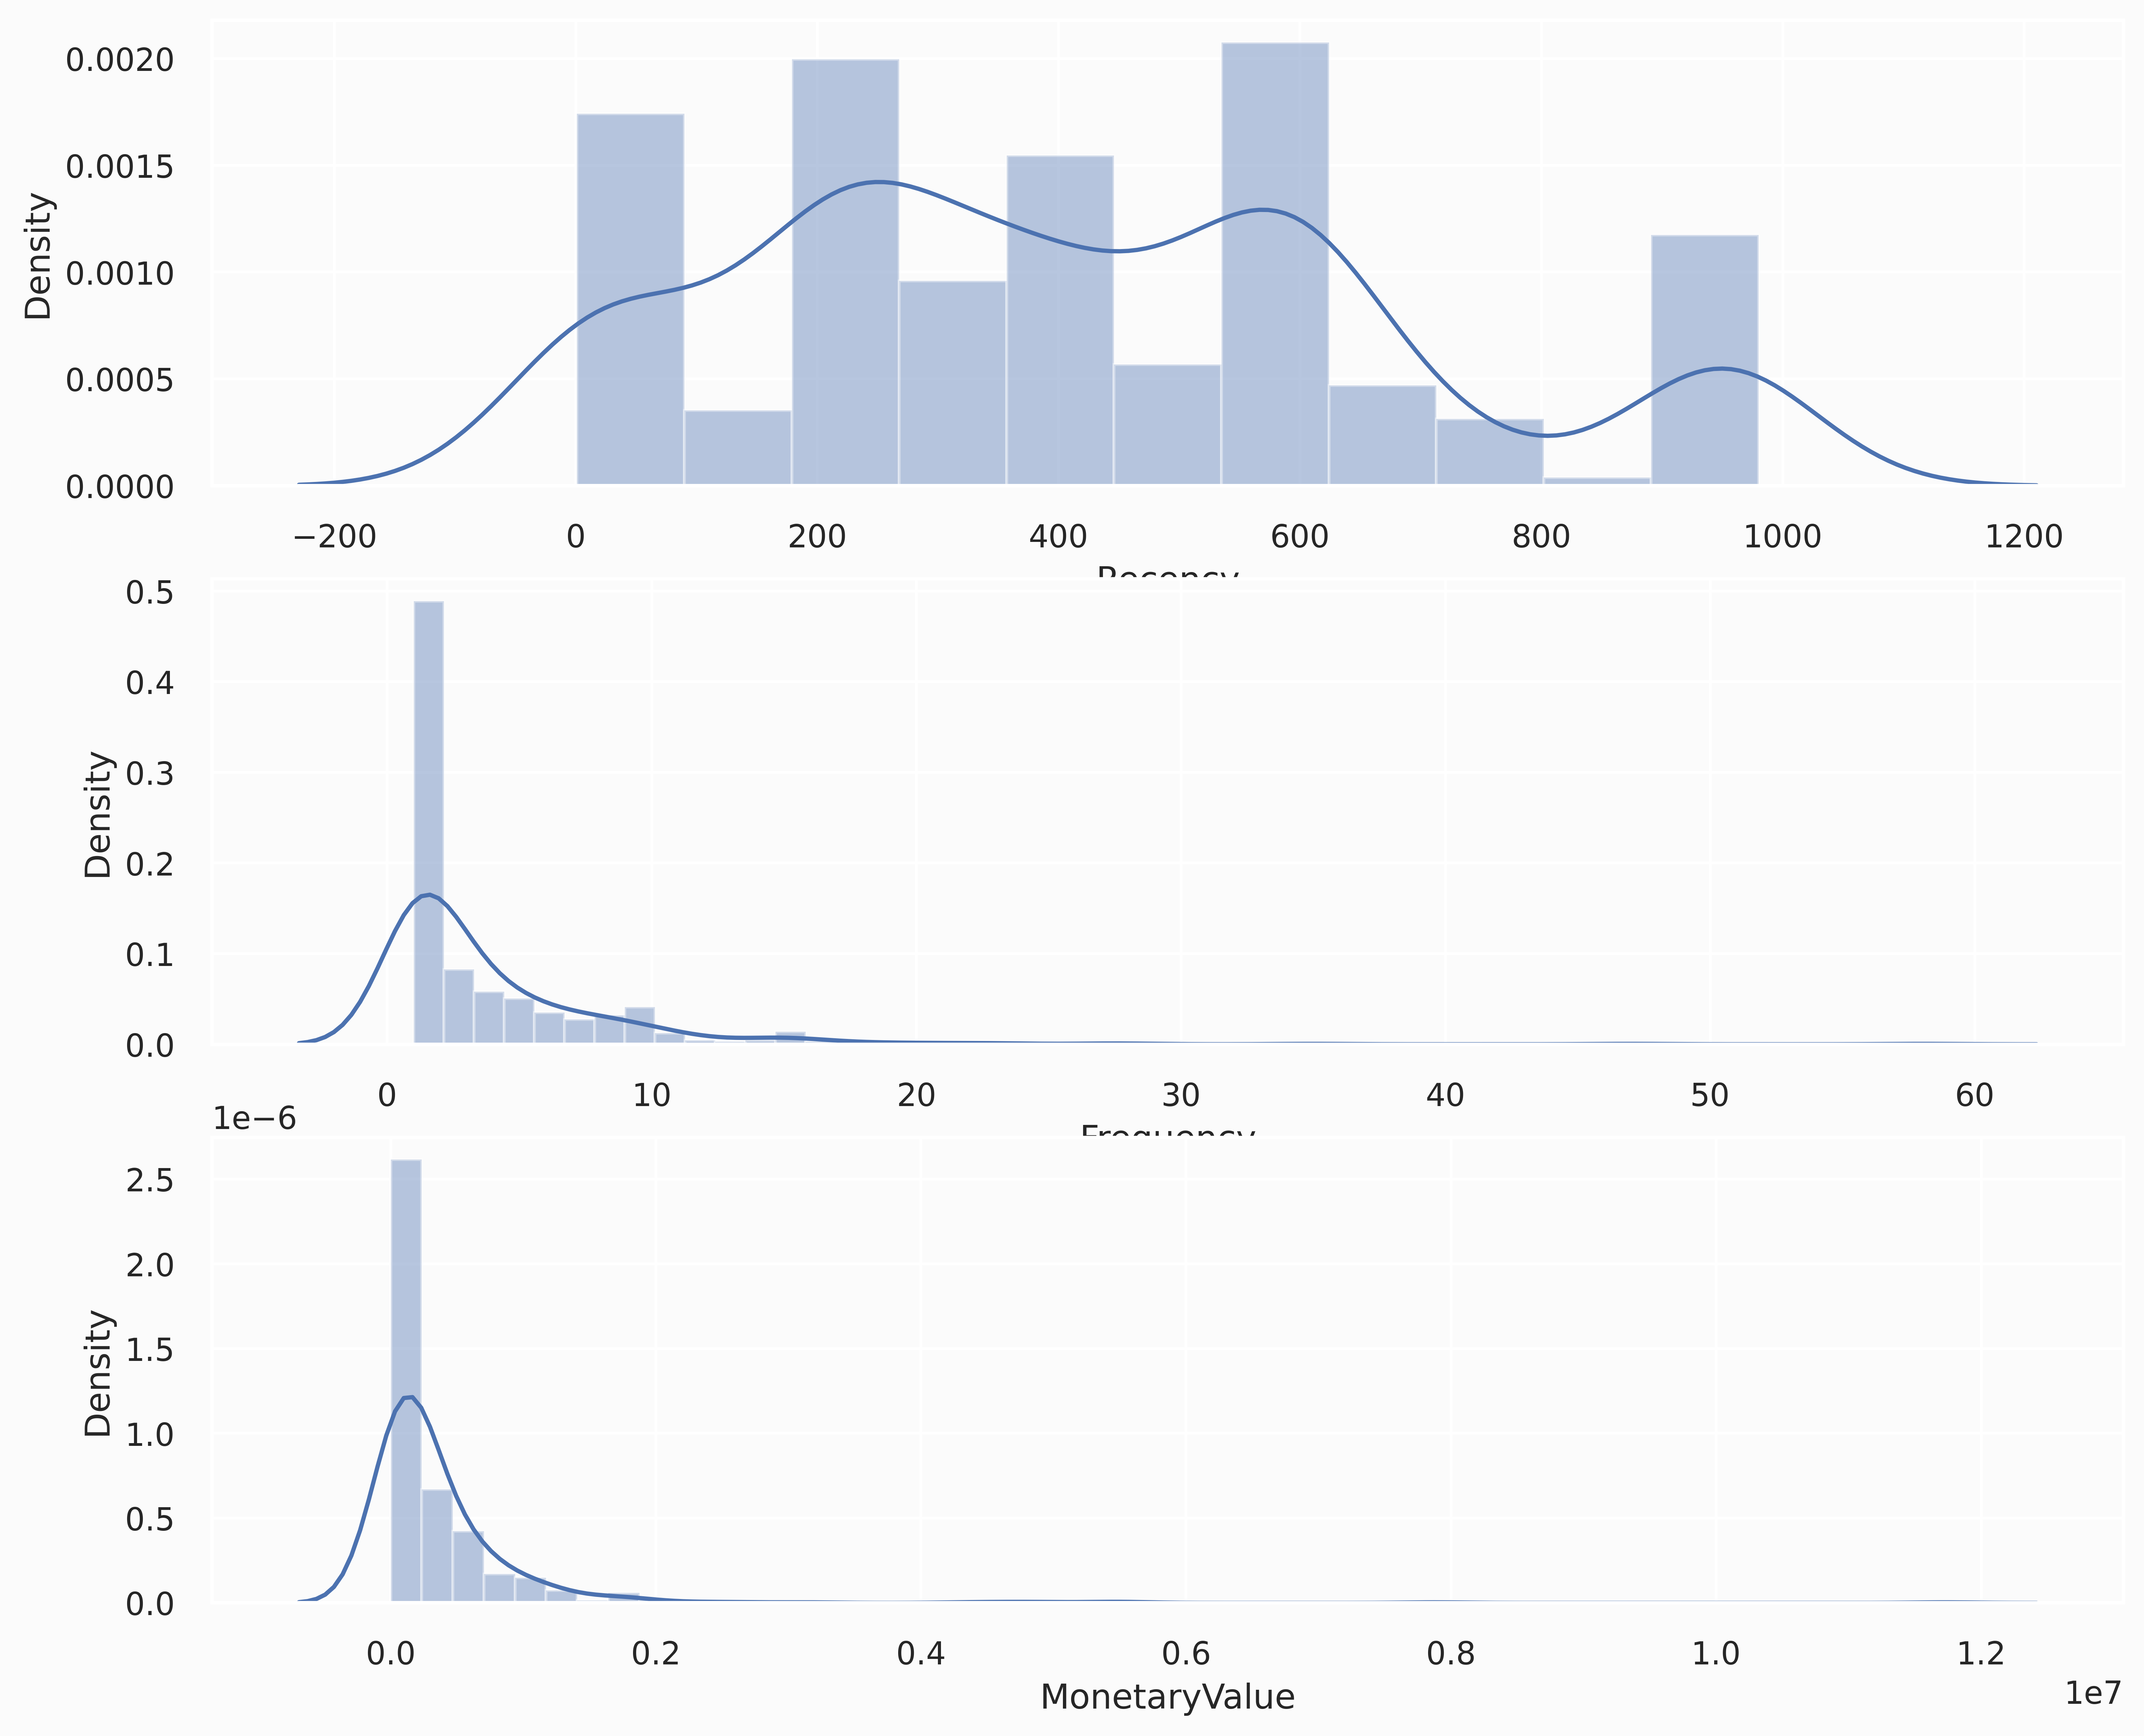

In [ ]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])

As we can see from the above plots, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness, we can try the following transformations:

1. log transformations
2. Box-Cox transformations
3. Cube root transformations

The log transformation cannot be used for negative values. One common practice one can use here is to add a constant value to get a positive value and this is generally taken as the absolute of the least negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset.

In [ ]:
# Checking for constant mean and variance.
data[['Recency','Frequency','MonetaryValue']].describe()

,Recency,Frequency,MonetaryValue
count,574.000000,574.000000,5.740000e+02
mean,409.738676,3.986063,3.892156e+05
std,273.488615,5.149406,8.218466e+05
min,1.000000,1.000000,0.000000e+00
25%,213.000000,1.000000,5.050000e+04
50%,371.500000,2.000000,1.500000e+05
75%,600.750000,5.000000,4.354760e+05
max,980.000000,58.000000,1.172500e+07


In [ ]:
data[data['MonetaryValue'] == 0]

,User_ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
334,U2021-0230,536,1,0.0,2,1,1,211,4,Low


In [ ]:
data = data[data['MonetaryValue'] > 0]
data.reset_index(drop=True,inplace=True)

In [ ]:
raw_data = data[['Recency','Frequency','MonetaryValue']]

Let us now apply log transformation to the data and normalize it.

In [ ]:
# Unskew the data
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(raw_data)

# Scale and center the data
data_normalized = scaler.transform(raw_data)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [ ]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,6.398595,1.791759,12.638829
1,6.850126,0.000000,10.819778
2,6.849066,0.000000,10.819778
3,5.594711,2.708050,13.962011
4,6.846943,1.098612,11.950961


Checking for skewness in the data now:

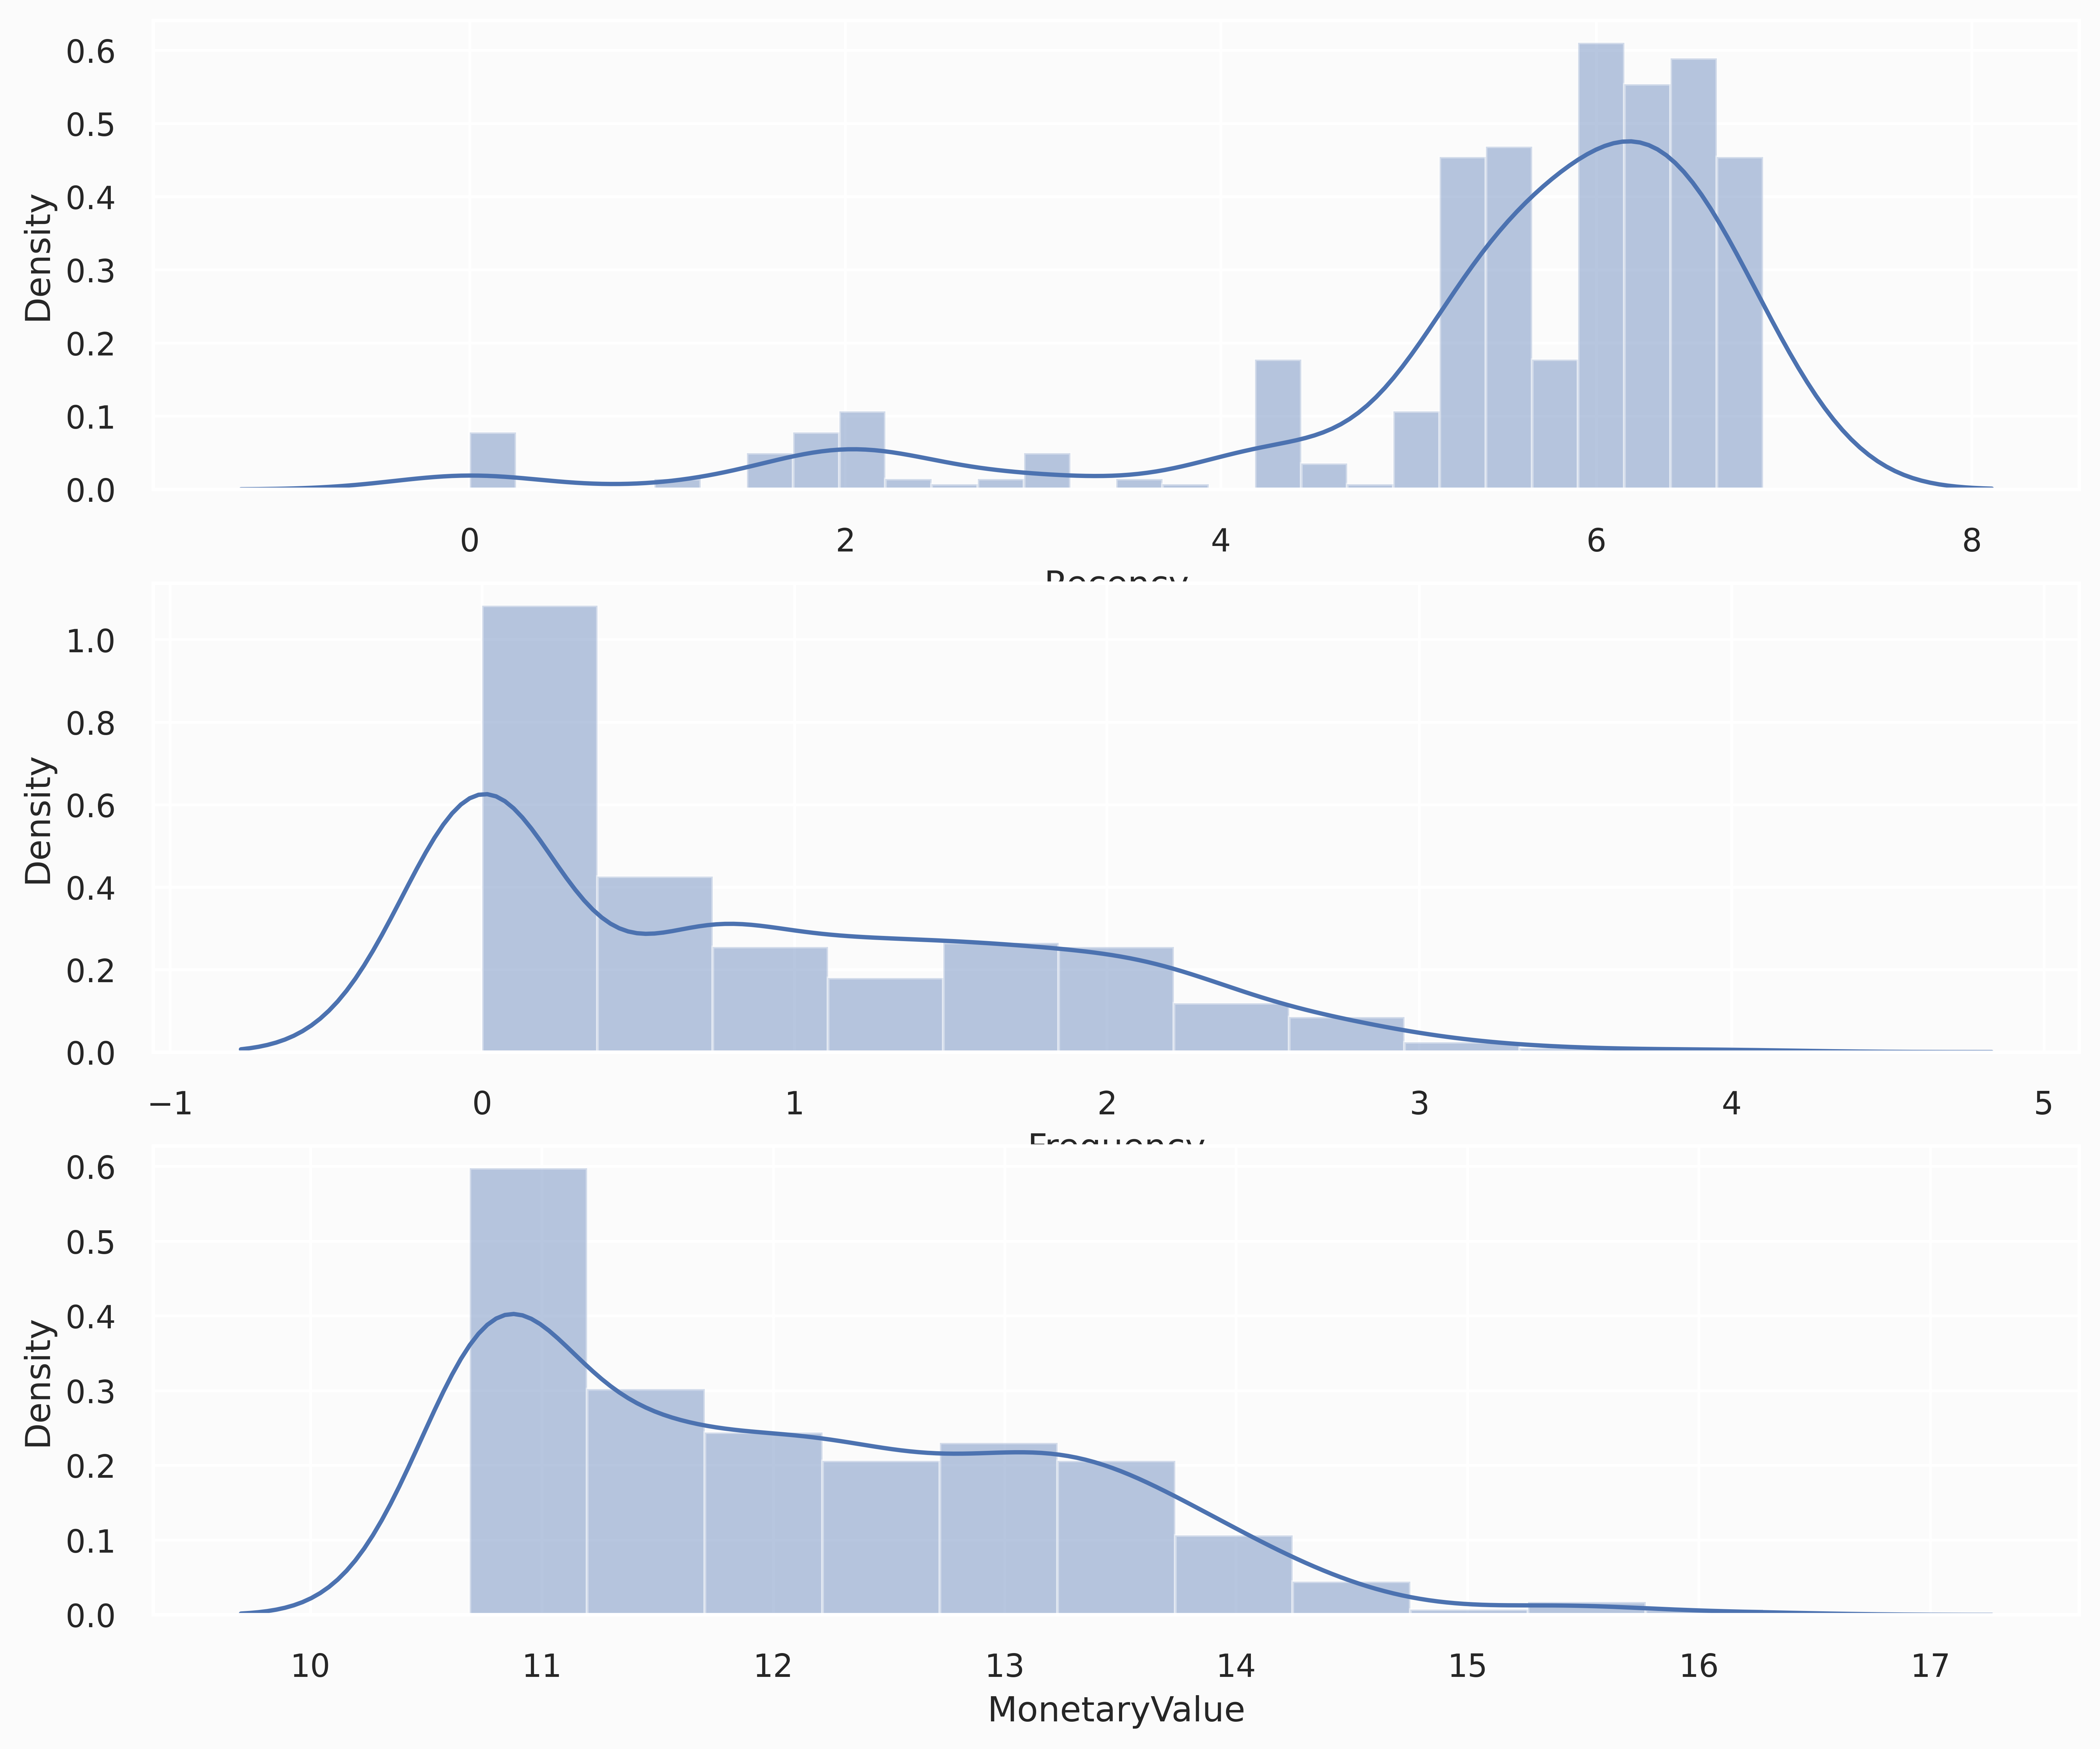

In [ ]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

# Show the plot
plt.show()

As we can see from the above plots, skewness has been removed from the data.

## Clustering with K-means algorithm

In this section, we will build multiple clusters upon our RFM data (data_norm) and will try to find out the optimal number of clusters in our data using the elbow method.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):

    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)

    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)

    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

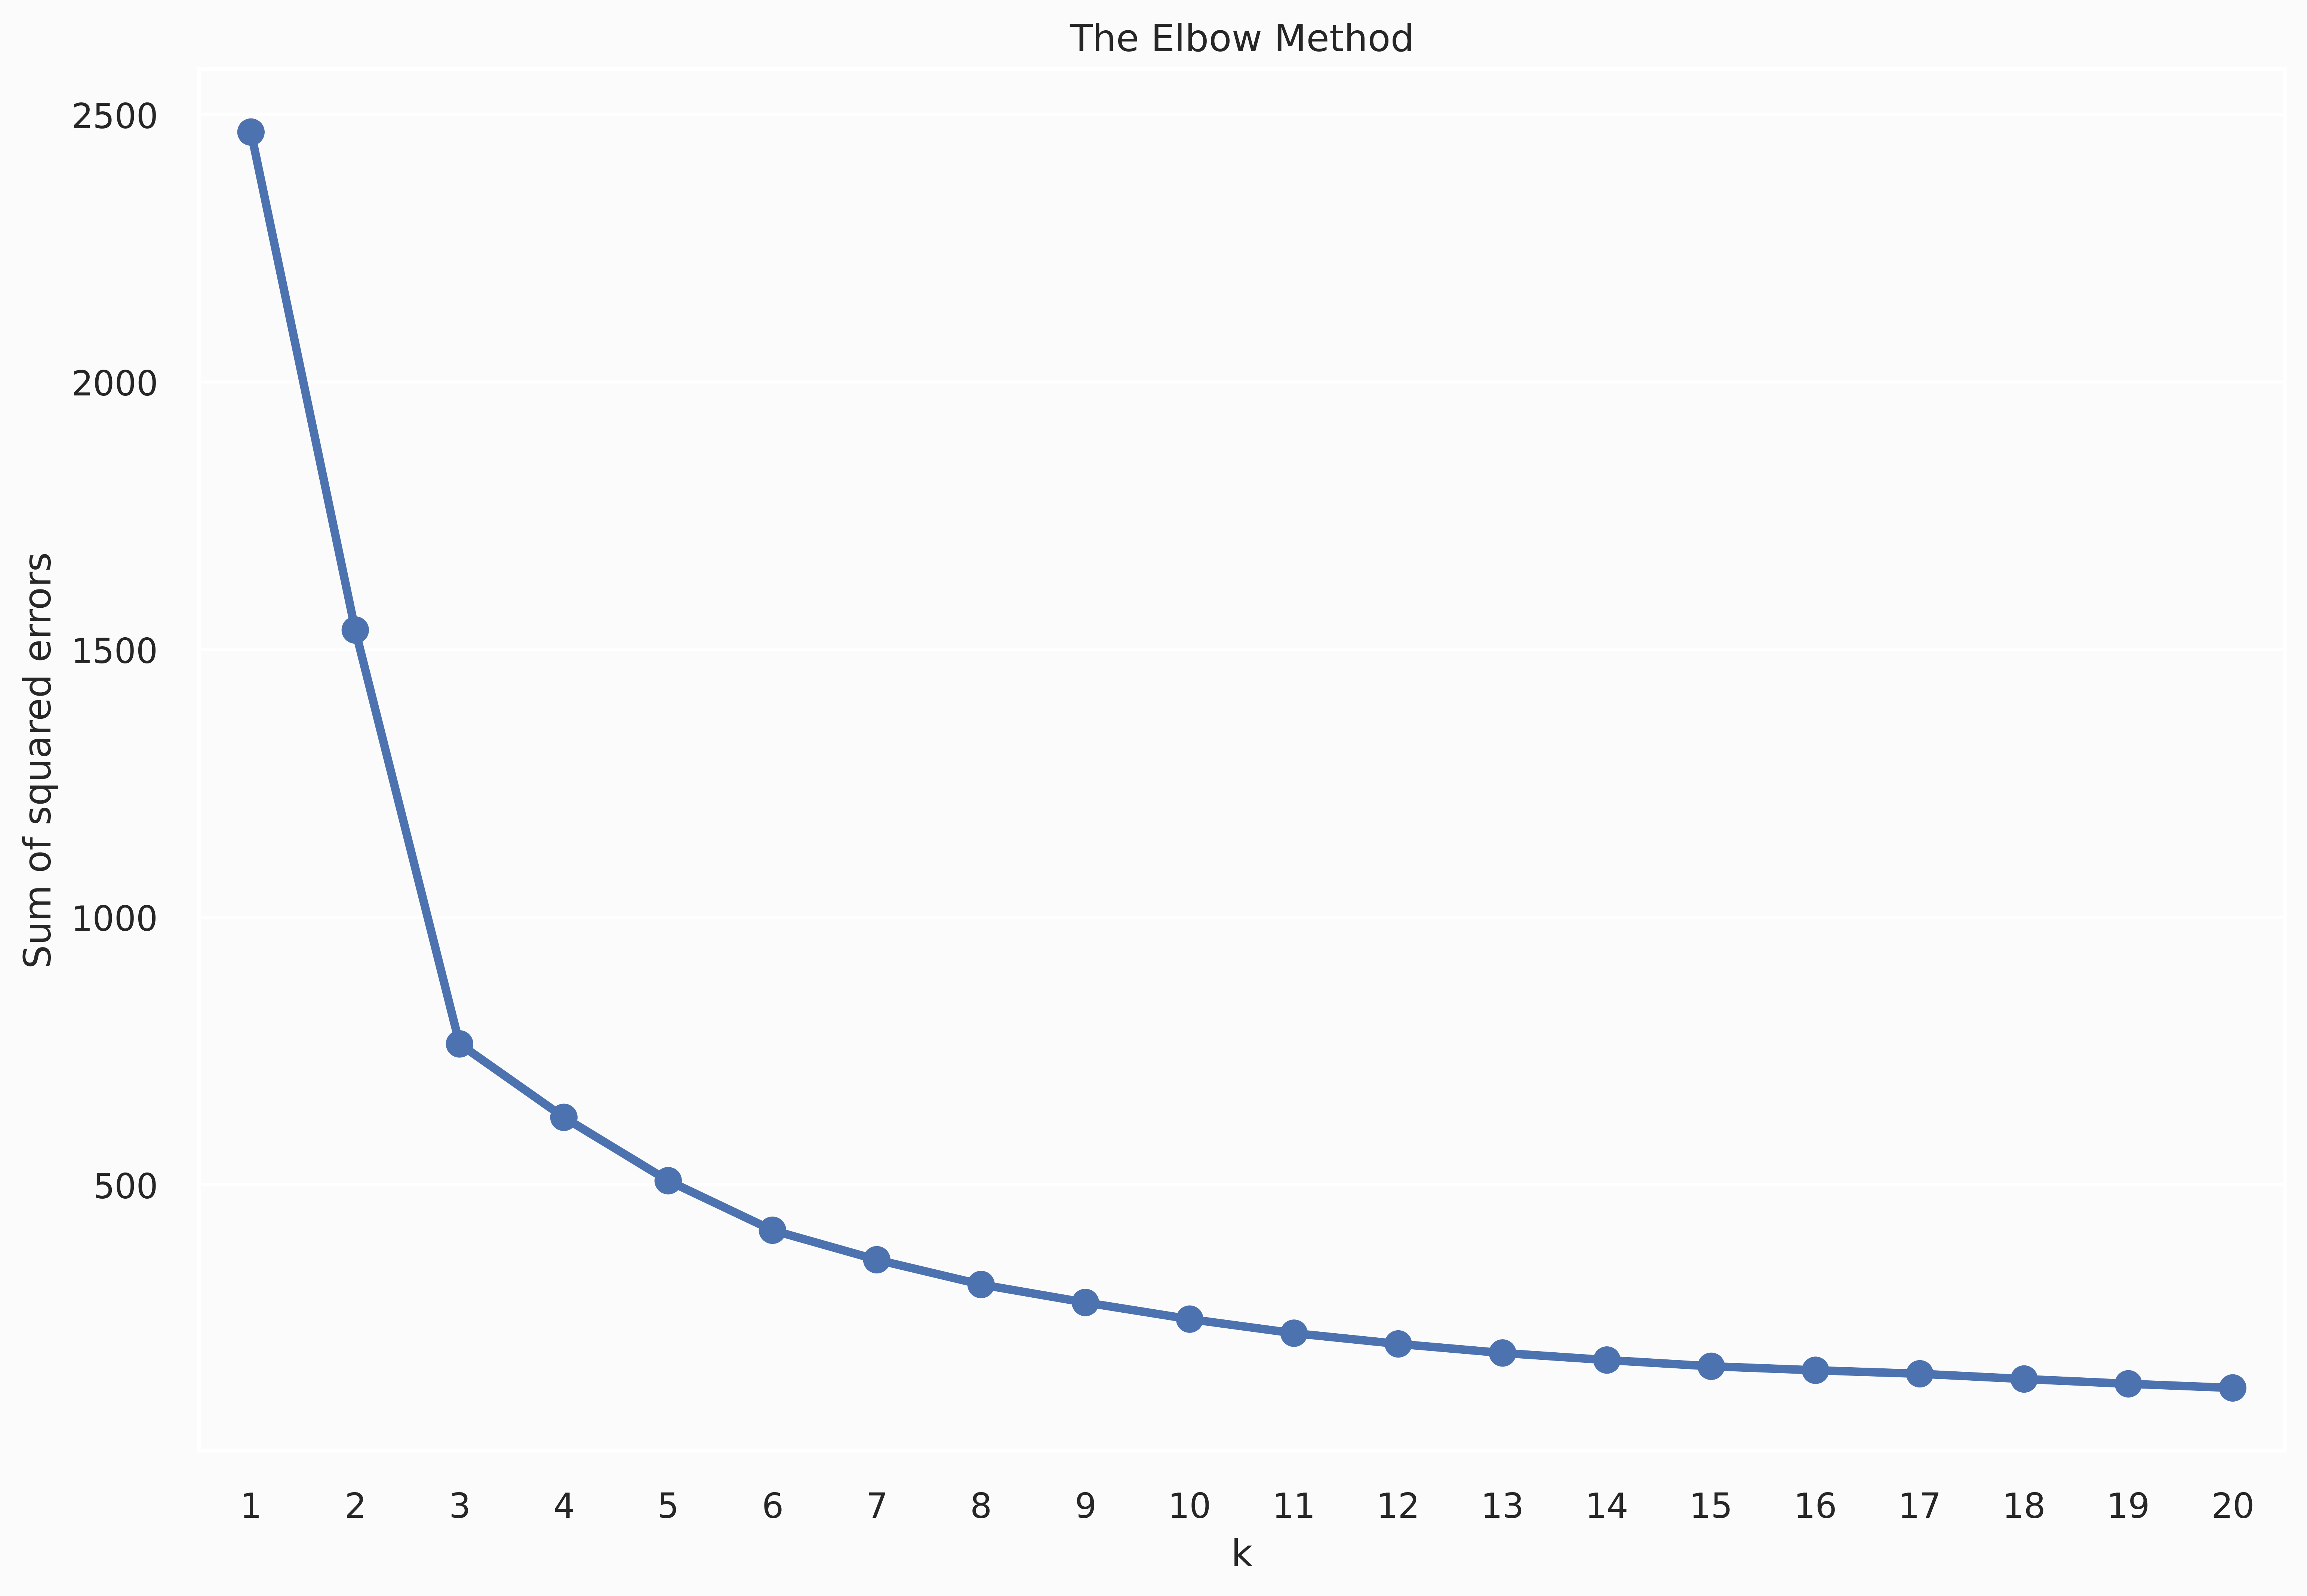

In [ ]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k');
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the above plot, we can see that the optimal number of cluster is 3 or 4.

Let us take k = 3 first.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0           7.0       4.0      383664.0    55
1         524.0       1.0       84200.0   298
2         355.0       7.0      805531.0   220

Let us now take k = 4.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         289.0      11.0     1342804.0    97
1         522.0       1.0       69455.0   252
2         442.0       4.0      322802.0   169
3           7.0       4.0      383664.0    55

## Profiling and interpreting segments

Let us view the results side by side.

In [ ]:
display(summary_k3)
display(summary_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0           7.0       4.0      383664.0    55
1         524.0       1.0       84200.0   298
2         355.0       7.0      805531.0   220

NameError: ignored

We can also build snakeplots to understand and compare the segments. Let us build a snakeplot for our data with 4 clusters below.

Before building snakeplots, let us assign back customerID values to the row indices.

In [ ]:
data_norm_k3.index = data['User_ID'].astype(str)

In [ ]:
data_norm_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
User_ID,,,,
U2020-0001,6.398595,1.791759,12.638829,2
U2020-0002,6.850126,0.000000,10.819778,1
U2020-0003,6.849066,0.000000,10.819778,1
U2020-0004,5.594711,2.708050,13.962011,2
U2020-0005,6.846943,1.098612,11.950961,1


In [ ]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k3.reset_index(),
                    id_vars=['User_ID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

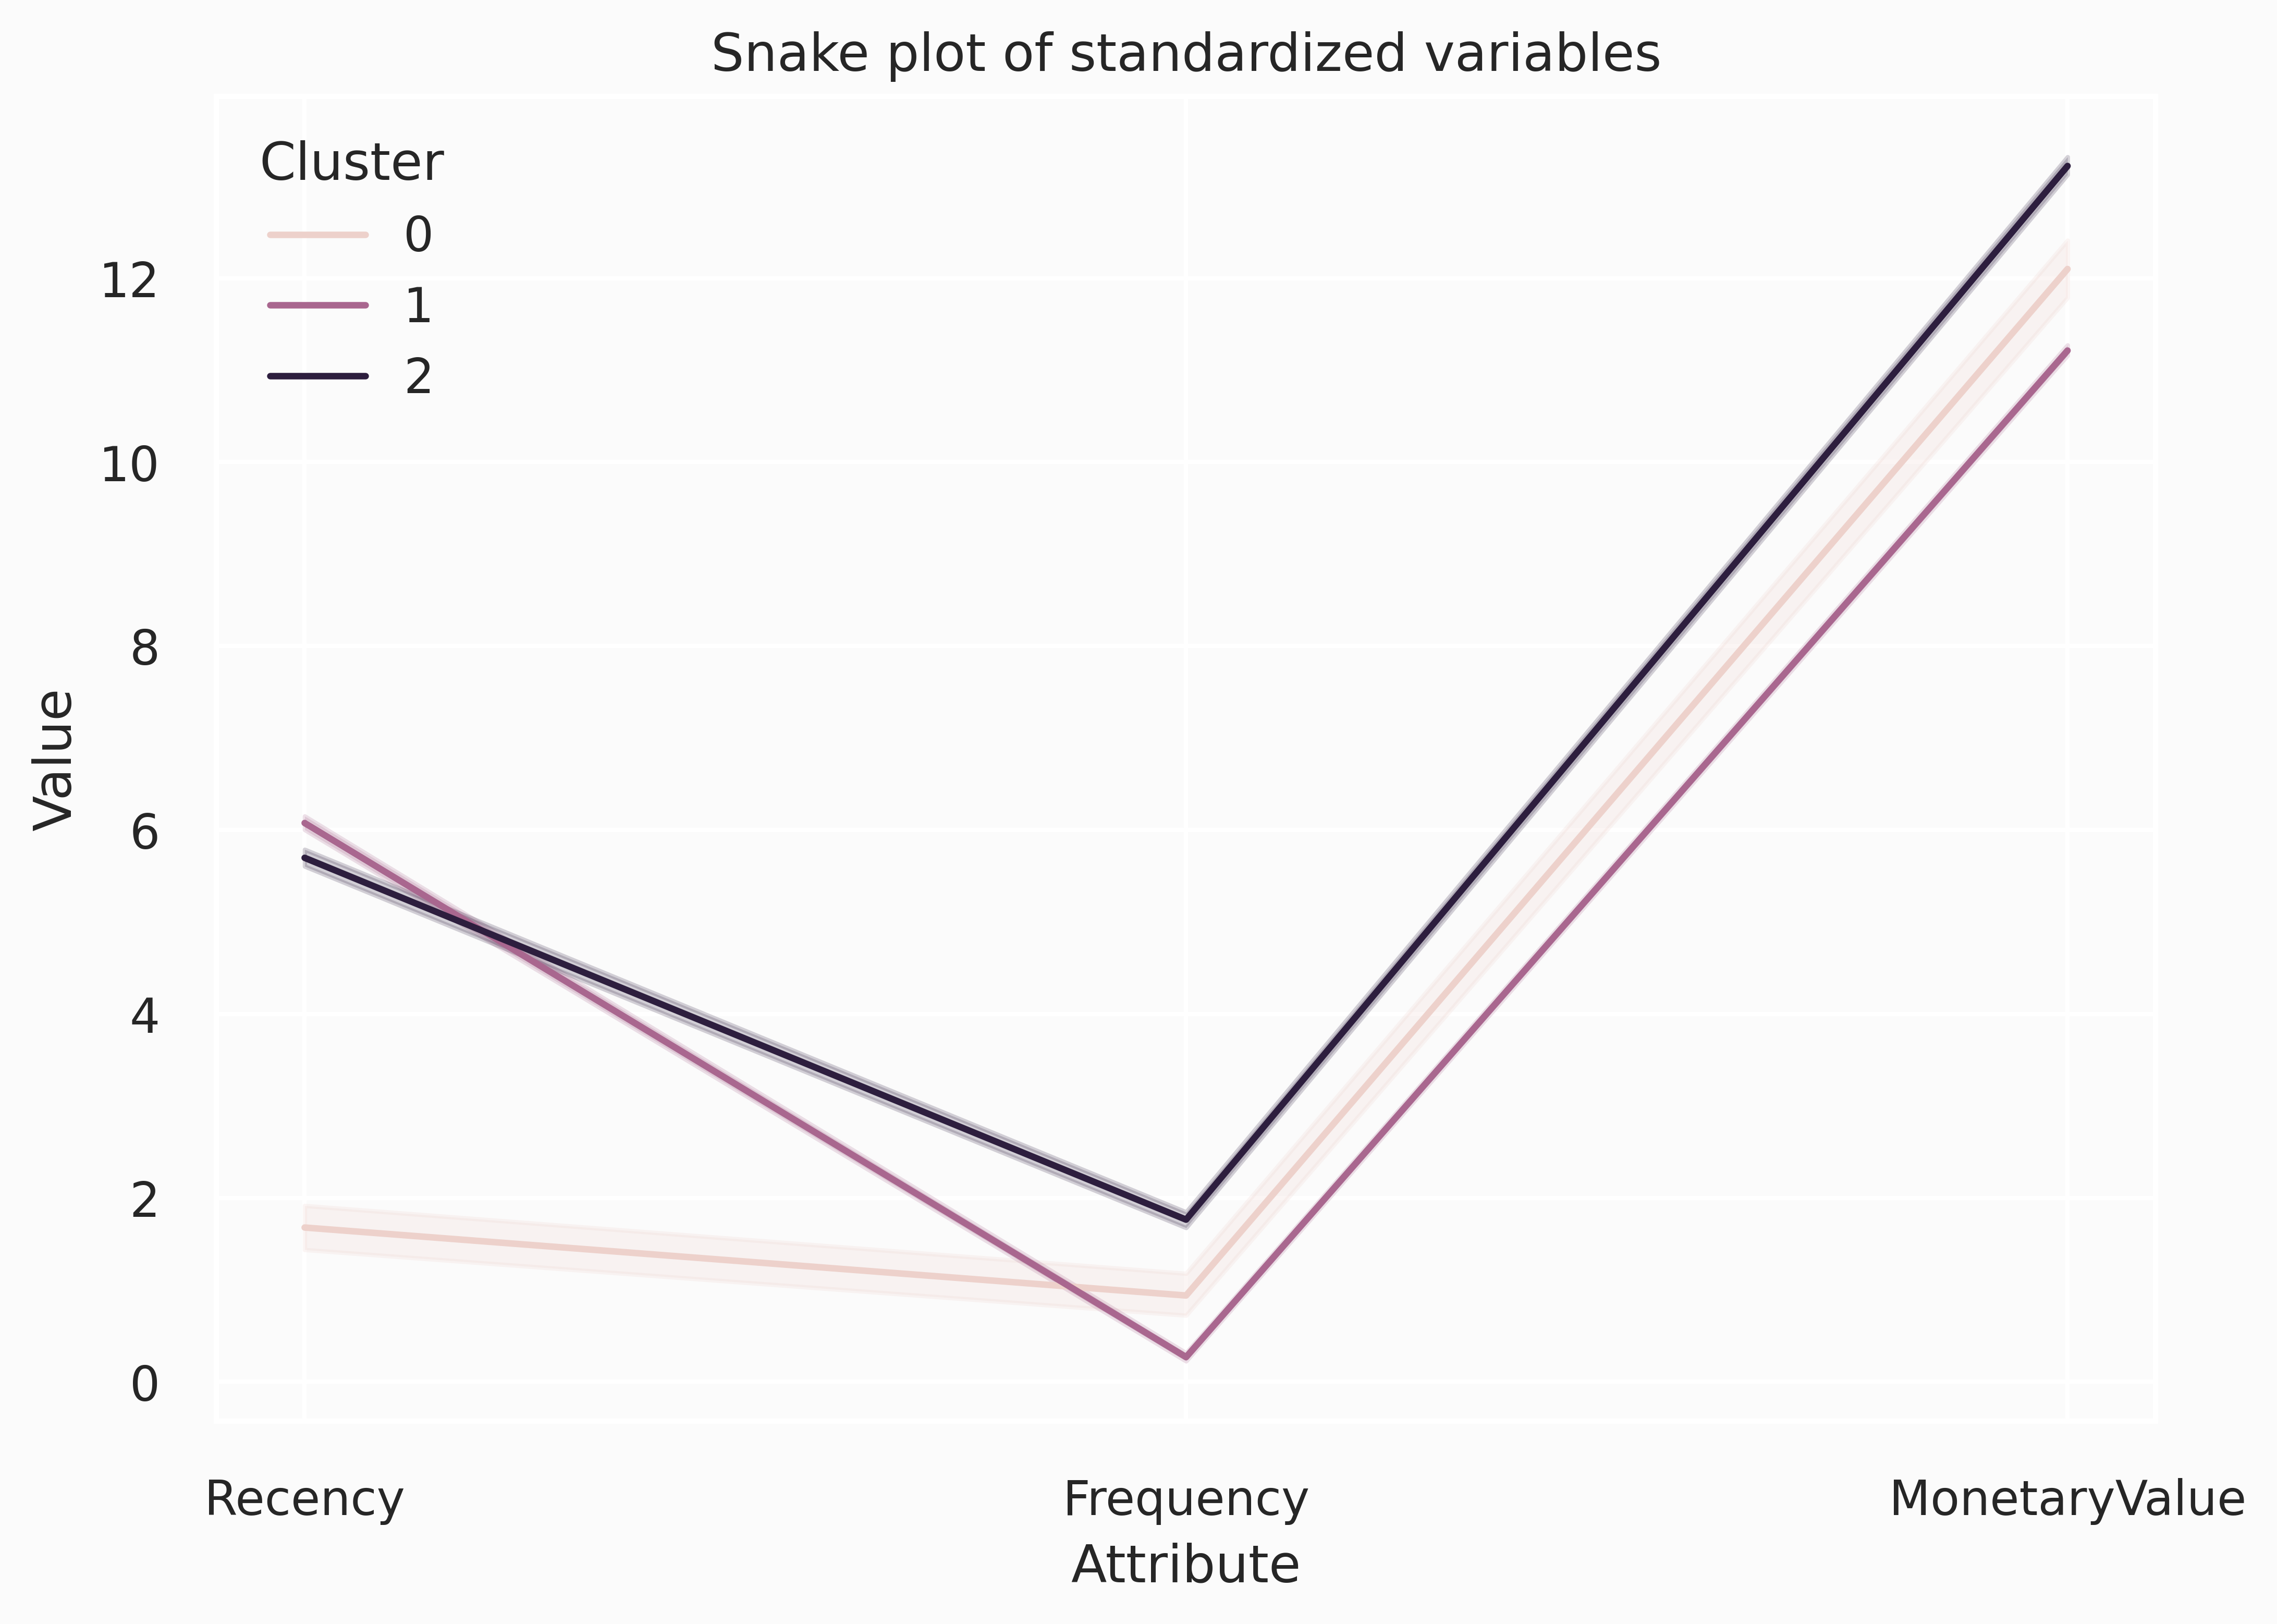

In [ ]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:
    1. Calculate average values of each cluster
    2. Calculate average values of population
    3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

Assigning CustomerID index to data_k4 dataframe:

In [ ]:
data_k3.index = data['User_ID'].astype(str)
data_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
User_ID,,,,
U2020-0001,601,6,308300.0,2
U2020-0002,944,1,50000.0,1
U2020-0003,943,1,50000.0,1
U2020-0004,269,15,1157775.0,2
U2020-0005,941,3,154966.0,1


Assigning CustomerID index to raw_data dataframe:

In [ ]:
raw_data.index = data['User_ID'].astype(str)
raw_data.head()

,Recency,Frequency,MonetaryValue
User_ID,,,
U2020-0001,601,6,308300.0
U2020-0002,944,1,50000.0
U2020-0003,943,1,50000.0
U2020-0004,269,15,1157775.0
U2020-0005,941,3,154966.0


In [ ]:
cluster_avg = data_k3.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [ ]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,7.490909,3.890909,383663.654545
1,524.013423,1.426174,84199.744966
2,354.936364,7.490909,805530.590909


In [ ]:
population_avg

Recency             739.6
Frequency             5.2
MonetaryValue    344208.2
dtype: float64

In [ ]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.99,-0.25,0.11
1,-0.29,-0.73,-0.76
2,-0.52,0.44,1.34


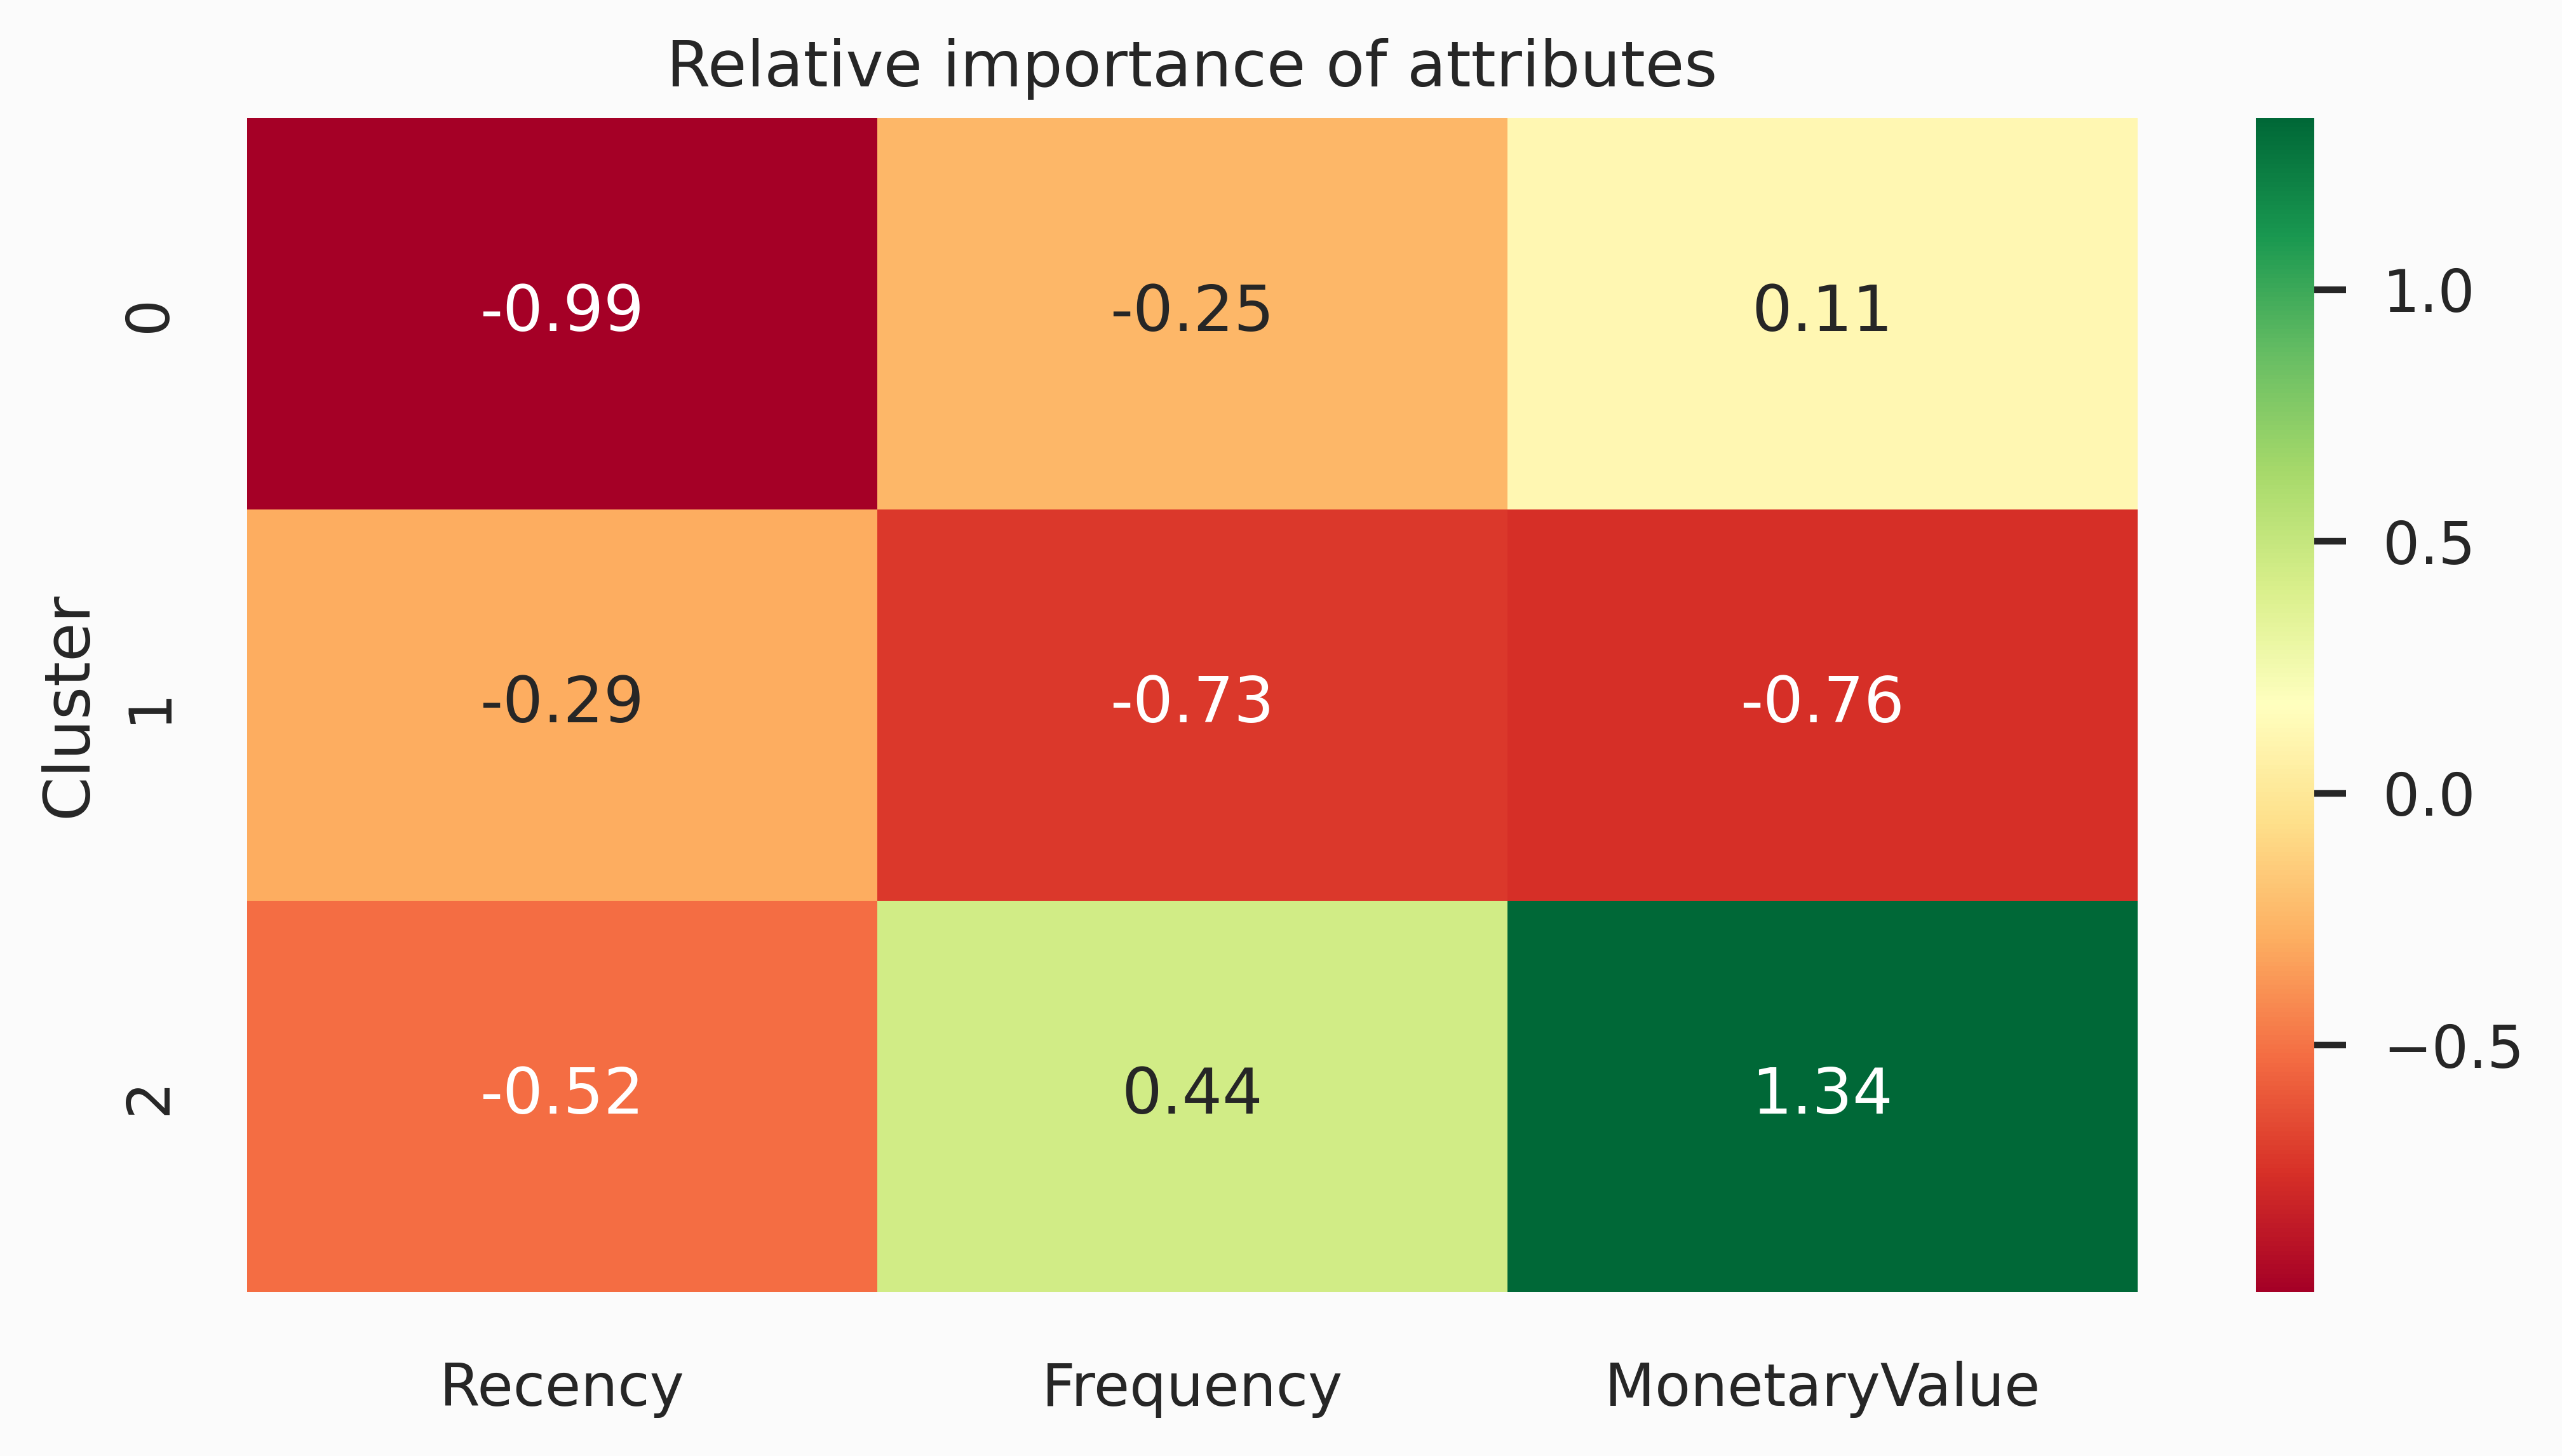

In [ ]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()